#The Fluties 

This is a statistical analysis of at this point 8 years of a fantasy football league. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

full_teams = pd.read_csv("teams.csv")

##Scaling the Data

The data needs scaled to account for difference between years. There may have been different amounts of teams, different scoring rules, or a myriad of other things. 

StandardScaler from Scikit-Learn helps by turning a numeric column into z-scores. These will be calculated per year. This allows for comparing across many years to be standardized. 

The last step is to drop some outliers. While the data is correct the points against column has 3 points that are almost 1 STD from the 4 point. In addition to this one of those has 8 wins. I am going to need to investigate that. On the top side there is the top observation that only has 7 wins. The 3rd worst points for team has more wins than the most points for team. These are both outliers and the model will be better for not using them.

In [2]:
scaler = StandardScaler()
def zscore(group):
    scaled = scaler.fit_transform(X=group[["record.overall.pointsFor", "record.overall.pointsAgainst", 'transactionCounter.moveToActive']])
    group["scaled_pointsFor"], group["scaled_pointsAgainst"], group["scaled_moves"] = scaled[:,0], scaled[:,1], scaled[:,2]
    return group

full_scaled_df = full_teams.groupby("year").apply(zscore)
scaled_df = full_scaled_df.loc[full_scaled_df["scaled_pointsFor"] > -2.5]
scaled_df = scaled_df.loc[scaled_df["scaled_pointsFor"] < 2.1]


###The Worst Teams

Notice the third worst with 8 wins.

In [3]:
full_scaled_df[["abbrev", "year", "scaled_pointsFor", "record.overall.pointsFor", "record.overall.wins"]].sort_values("scaled_pointsFor").head(5)

,abbrev,year,scaled_pointsFor,record.overall.pointsFor,record.overall.wins
23,STP,2012,-2.930836,953.0,2
67,JJC,2016,-2.671726,1064.8,4
55,JJC,2015,-2.524540,1293.8,8
46,TSHU,2014,-1.674177,1305.6,3
86,SCD,2017,-1.627489,1117.2,4


###The Best Teams

In [4]:
full_scaled_df[["abbrev", "year", "scaled_pointsFor", "record.overall.pointsFor", "record.overall.wins"]].sort_values("scaled_pointsFor", ascending=False).head(5)

,abbrev,year,scaled_pointsFor,record.overall.pointsFor,record.overall.wins
111,JFSF,2019,2.158259,1916.6,7
88,#1,2018,2.084734,2263.1,10
37,JJJ,2013,2.029172,1754.6,9
44,DURA,2014,1.875039,1696.4,8
8,faq,2020,1.743053,2064.4,10


##Distribution

Here is everything laid out in a box plot. The outliers are preserved so they can be easily visualized. These are not included in calculations.

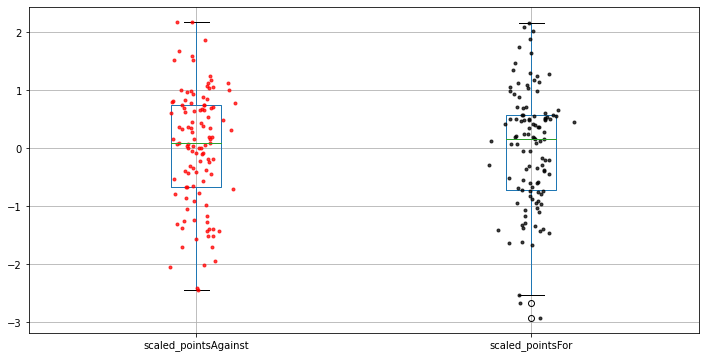

In [5]:
ax = full_scaled_df.boxplot(column=["scaled_pointsAgainst", "scaled_pointsFor"], figsize=(12,6))
for index, t in full_scaled_df.iterrows():
    y = t["scaled_pointsFor"]
    x = np.random.normal(2, 0.04)
    ax.plot(x, y, 'k.', alpha=0.75)
    y_for = t["scaled_pointsAgainst"]
    x_for = np.random.normal(1, 0.04)
    ax.plot(x_for, y_for, 'r.', alpha=0.75)


##Linear Regression

The models show that the correlation is weak. The charts do show that it exists. Wins being so discrete allows more outliers from the fitted line. A win or loss by 0.1 point is still a discrete win or loss.

In [6]:
for_mod = sm.OLS(scaled_df['record.overall.wins'], sm.add_constant(scaled_df['scaled_pointsFor']))
for_res = for_mod.fit()

against_mod = sm.OLS(scaled_df['record.overall.wins'], sm.add_constant(scaled_df['scaled_pointsAgainst']))
against_res = against_mod.fit()

moves_mod = sm.OLS(scaled_df['record.overall.wins'], sm.add_constant(scaled_df['scaled_moves']))
moves_res = against_mod.fit()

In [7]:
for_res.rsquared

0.410837002842395

In [8]:
against_res.rsquared

0.3826479681342695

In [9]:
moves_res.rsquared

0.3826479681342695

Text(0.5, 0, 'Moves')

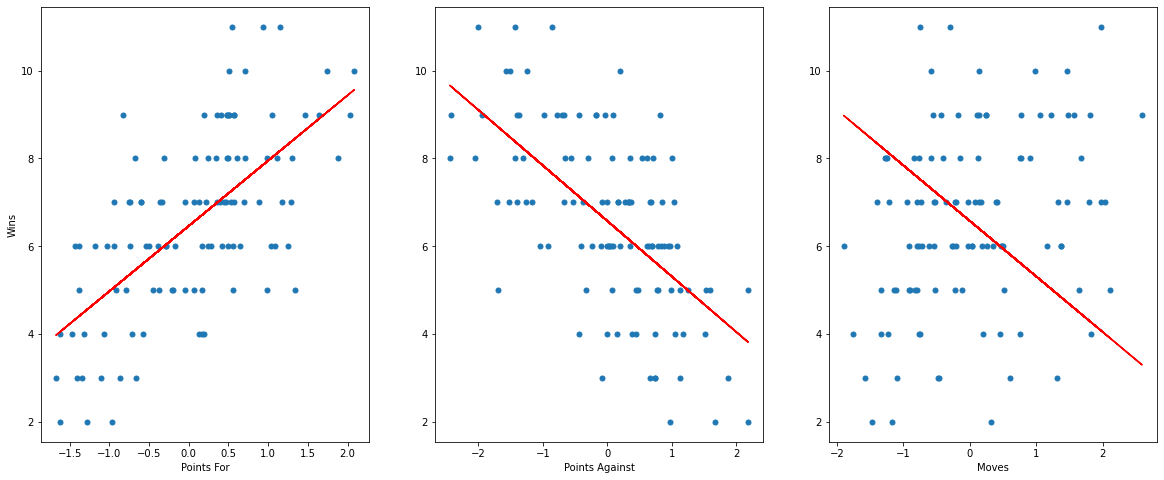

In [10]:
def regress_plot(slope, intercept, x, y, plt):
    plt.plot(x, y, 'o', markersize=5)

    plt.plot(x, slope*x + intercept, 'r')
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
regress_plot(for_res.params[1], for_res.params[0], scaled_df['scaled_pointsFor'], scaled_df['record.overall.wins'], ax[0])
regress_plot(against_res.params[1], against_res.params[0], scaled_df['scaled_pointsAgainst'], scaled_df['record.overall.wins'], ax[1])
regress_plot(moves_res.params[1], moves_res.params[0], scaled_df['scaled_moves'], scaled_df['record.overall.wins'], ax[2])
ax[0].set_xlabel('Points For')
ax[0].set_ylabel('Wins')
ax[1].set_xlabel('Points Against')
ax[2].set_xlabel('Moves')

##Multiple Variable Regression

Points for and points against will get a fairly strong correaltion to wins. 

In [11]:
both_mod = sm.OLS(scaled_df['record.overall.wins'], sm.add_constant(scaled_df[['scaled_pointsFor', 'scaled_pointsAgainst']]))
both_res = both_mod.fit()

both_res.summary()
#both_mod = sm.RLM(scaled_df['record.overall.wins'], sm.add_constant(scaled_df[['scaled_pointsFor', 'scaled_pointsAgainst']]), M=sm.robust.norms.AndrewWave())
#both_res = both_mod.fit()
#both_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     record.overall.wins   R-squared:                       0.663
Model:                             OLS   Adj. R-squared:                  0.656
Method:                  Least Squares   F-statistic:                     103.1
Date:                 Thu, 10 Dec 2020   Prob (F-statistic):           1.67e-25
Time:                         16:44:28   Log-Likelihood:                -172.44
No. Observations:                  108   AIC:                             350.9
Df Residuals:                      105   BIC:                             358.9
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5030      0.117     55.640      0.000       6.271       6.735
scaled_pointsFor         1.2520      0.134      9.336      0.000       0.986       1.518
scaled_pointsAgainst    -1.0456      0.118     -8.853      0.000      -1.280      -0.811
==============================================================================
Omnibus:                        7.452   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                3.139
Skew:                          -0.041   Prob(JB):                        0.208
Kurtosis:                       2.169   Cond. No.                         1.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###2020 Corrections

Corrections based on the entire history of the league.

In [12]:
scaled_df["residuals"] = both_res.resid
scaled_df["pred_wins"] = both_res.fittedvalues

current = scaled_df.loc[scaled_df["year"] == 2020]
current[["abbrev", "year", "record.overall.wins", "pred_wins", "residuals", "playoffSeed"]].sort_values("pred_wins", ascending=False).head(12)

,abbrev,year,record.overall.wins,pred_wins,residuals,playoffSeed
8,faq,2020,10,10.329187,-0.329187,2
0,#1,2020,11,8.575470,2.424530,1
6,BBc,2020,9,8.244930,0.755070,3
3,TMB,2020,7,7.669573,-0.669573,7
10,No,2020,7,7.613257,-0.613257,6
1,GUY,2020,8,6.540558,1.459442,5
7,#50%,2020,7,6.047958,0.952042,8
9,JJJ,2020,5,5.871438,-0.871438,9
4,Mill,2020,4,5.620234,-1.620234,10
2,Seth,2020,6,5.471598,0.528402,4


###All Time Underperformers

In [13]:
scaled_df[["abbrev", "year", "record.overall.wins", "pred_wins", "residuals", "playoffSeed"]].sort_values("residuals").head(10)

,abbrev,year,record.overall.wins,pred_wins,residuals,playoffSeed
62,SCD,2015,4,6.714862,-2.714862,12
97,JJJ,2018,4,6.253519,-2.253519,10
36,DURA,2013,6,8.113024,-2.113024,8
19,HOLD,2012,4,6.074784,-2.074784,15
59,SSGW,2015,4,5.968907,-1.968907,11
107,#50%,2019,5,6.907037,-1.907037,11
79,JJC,2017,3,4.905013,-1.905013,12
66,Seth,2016,3,4.898127,-1.898127,11
80,Mill,2017,7,8.833558,-1.833558,5
110,SCD,2019,6,7.770289,-1.770289,9


###All Time Overperformers

In [14]:
scaled_df[["abbrev", "year", "record.overall.wins", "pred_wins", "residuals", "playoffSeed"]].sort_values("residuals", ascending=False).head(10)

,abbrev,year,record.overall.wins,pred_wins,residuals,playoffSeed
0,#1,2020,11,8.575470,2.424530,1
109,JJJ,2019,7,4.658772,2.341228,2
95,#WIN,2018,7,4.881684,2.118316,7
16,WRIG,2012,6,3.906128,2.093872,10
31,KMU,2013,6,3.992009,2.007991,6
72,win,2016,9,6.993100,2.006900,5
105,TWS,2019,7,5.157239,1.842761,3
82,JIAT,2017,11,9.277254,1.722746,1
83,#WIN,2017,9,7.293057,1.706943,2
70,JIAT,2016,8,6.297734,1.702266,3


In [15]:
full_scaled_df.to_csv("scaled_teams.csv")

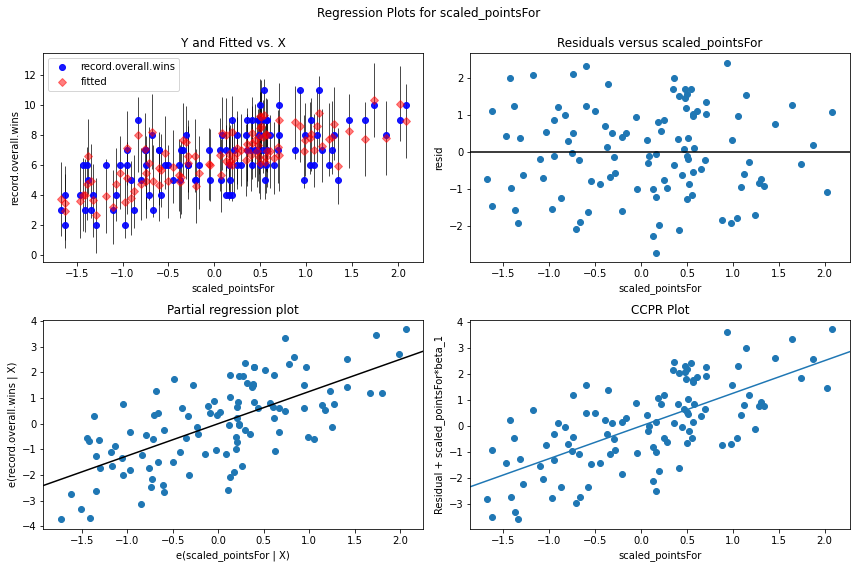

In [16]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(both_res, "scaled_pointsFor", fig=fig)